# Importar dados

In [22]:
import numpy as np 

feature = np.load('data/feature.npy')
target = np.load('data/target.npy')

print(f"Shape das  feature: {feature.shape}")
print(f"Shape dos target: {target.shape}")

Shape das  feature: (1898, 10, 77)
Shape dos target: (1899, 10)


# Infraestrutura dos dados (dataloader)

## Dividindo em treino e teste 

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [24]:
X_train, X_test, y_train, y_test = train_test_split(feature, target[:-1], test_size=0.2, shuffle=False)

# Verifique as formas após o split
print(f"Shape das features de treino: {X_train.shape}")
print(f"Shape das features de teste: {X_test.shape}")
print(f"Shape do target de treino: {y_train.shape}")
print(f"Shape do target de teste: {y_test.shape}")


Shape das features de treino: (1518, 10, 77)
Shape das features de teste: (380, 10, 77)
Shape do target de treino: (1518, 10)
Shape do target de teste: (380, 10)


## Normalizando

In [25]:

scaler_X = MinMaxScaler()

# Reshape para 2D: (n_samples * 10, n_features)
X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])  # De (n_samples, 10, 3) para (n_samples*10, 3)
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

# Ajuste o scaler nas features de treino e normalizar
X_train_scaled = scaler_X.fit_transform(X_train_reshaped)
X_test_scaled = scaler_X.transform(X_test_reshaped)

# Reshape de volta para (n_samples, 10, n_features)
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# Verifique o shape após a transformação
print(f"Shape das features de treino após normalização: {X_train_scaled.shape}")
print(f"Shape das features de teste após normalização: {X_test_scaled.shape}")


scaler_y = MinMaxScaler()

# Ajustar o scaler no target de treino e normalizar
y_train_scaled = scaler_y.fit_transform(y_train)  
y_test_scaled = scaler_y.transform(y_test) 

# Verifique o shape após a transformação
print(f"Shape do target de treino após normalização: {y_train_scaled.shape}")
print(f"Shape do target de teste após normalização: {y_test_scaled.shape}")

Shape das features de treino após normalização: (1518, 10, 77)
Shape das features de teste após normalização: (380, 10, 77)
Shape do target de treino após normalização: (1518, 10)
Shape do target de teste após normalização: (380, 10)


## Criando um dataSet e utilizando o dataloader

In [26]:
from torch.utils.data import DataLoader, Dataset

In [27]:
class CustomDataset(Dataset):
    def __init__(self,feature,label):
        self.feature = feature
        self.label = label

    def __len__(self):
        len_feature = len(self.feature)
        return len_feature

    def __getitem__(self, index):
        feature = self.feature[index,:]
        label = self.label[index]
        return feature, label


In [28]:
dataset_treino = CustomDataset(X_train_scaled,y_train_scaled)
dataset_teste = CustomDataset(X_test_scaled,y_test_scaled)


## Criando dataloader

In [29]:
batch_size = 128
train_dataloader = DataLoader(dataset_treino, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(dataset_teste, batch_size=batch_size, shuffle=False)


In [30]:
import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Modelo

In [31]:
from torch import nn

In [32]:
class LSTMModel(nn.Module):
  def __init__(self, input_size=1, hidden_size=50, output_size=1):
    super().__init__()
    self.lstm= nn.LSTM(input_size,hidden_size,batch_first=True)
    self.linear = nn.Linear(hidden_size,output_size)

  def forward(self,x):
    lstm_out, _ = self.lstm(x)
    return self.linear(lstm_out[:,-1])

## hiperparametros

In [33]:
entrada = X_test_scaled.shape[2]
saida = y_test_scaled.shape[1]

In [34]:
modelo = LSTMModel(entrada,100,output_size=saida).to(device)
funcao_de_custo = nn.MSELoss()
otimizador = torch.optim.Adam(modelo.parameters(), lr=1e-3)

## Função Treino

In [35]:
def train(modelo, dataloader, funcao_de_custo, otimizador, device):
    modelo.train()  # Prepara o modelo para o modo de treinamento
    erro_acumulativo = 0.0
    
    for _, (data, target) in enumerate(dataloader):
        target, datas = target.float().to(device), data.float().to(device)
        
        # Passa os dados pela RNN
        pred = modelo(datas)
        
        # Calcula a perda
        perda = funcao_de_custo(pred, target.to(device))  # Já no mesmo dispositivo
        
        # Zero os gradientes acumulados
        otimizador.zero_grad()  
        
        # Calcula o gradiente
        perda.backward()
        
        # Atualiza os pesos
        otimizador.step()
        
        # Acumula a perda
        erro_acumulativo += perda.item()
    
    # Retorna a perda média
    return erro_acumulativo / len(dataloader)


## Teste

In [36]:
def test(modelo, dataloader, funcao_de_custo, device):
    modelo.eval()  # Coloca o modelo em modo de avaliação
    total_loss = 0.0
    
    with torch.no_grad():  # Desativa o cálculo dos gradientes para economizar memória e computação
        for _, (data, target) in enumerate(dataloader):
            target, datas = target.float().to(device), data.float().to(device)
            
            # Passa os dados pela RNN
            pred = modelo(datas)
            
            # Calcula a perda
            loss = funcao_de_custo(pred, target.to(device))
            
            # Acumula a perda
            total_loss += loss.item()

    # Retorna a perda média
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss


## Treinando

In [37]:
vezes_treinando = 200
for t in range(vezes_treinando):
  train_erro = train(modelo,train_dataloader,funcao_de_custo,otimizador,device)
  if t %50 ==0:
    print(f"Epoca {t}; erro : {train_erro}")
  test_erro = test(modelo,test_dataloader,funcao_de_custo,device)
print(f"erro : {test_erro}")

Epoca 0; erro : 0.12221165249745052
Epoca 50; erro : 0.0036384366103447974
Epoca 100; erro : 0.0024545930937165394
Epoca 150; erro : 0.0022970508822860816
erro : 0.03415683579320709


# Resultados

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# 1. Obter as previsões e os valores reais do conjunto de teste
modelo.eval()

# Listas para armazenar as previsões e os valores reais
predicoes = []
real = []

with torch.no_grad():
    for data, target in test_dataloader:
        data, target = data.float().to(device), target.float().to(device)
        
        # Realizar a previsão com o modelo
        pred = modelo(data)
        
        # Armazenar as previsões e os valores reais
        predicoes.append(pred.cpu().numpy())
        real.append(target.cpu().numpy())

# Concatenar as listas para formar arrays
predicoes = np.concatenate(predicoes, axis=0)
real = np.concatenate(real, axis=0)



In [39]:
predicoes[-1]

array([0.35053498, 0.8715228 , 0.9680965 , 1.6588413 , 0.12024213,
       1.0379072 , 1.1248863 , 0.66954756, 0.9939233 , 1.1030155 ],
      dtype=float32)

In [40]:
real[-1]

array([0.27400205, 1.2569544 , 0.7403697 , 2.4527845 , 0.02421808,
       1.0689825 , 1.6086643 , 0.8444515 , 0.93915564, 1.2657286 ],
      dtype=float32)

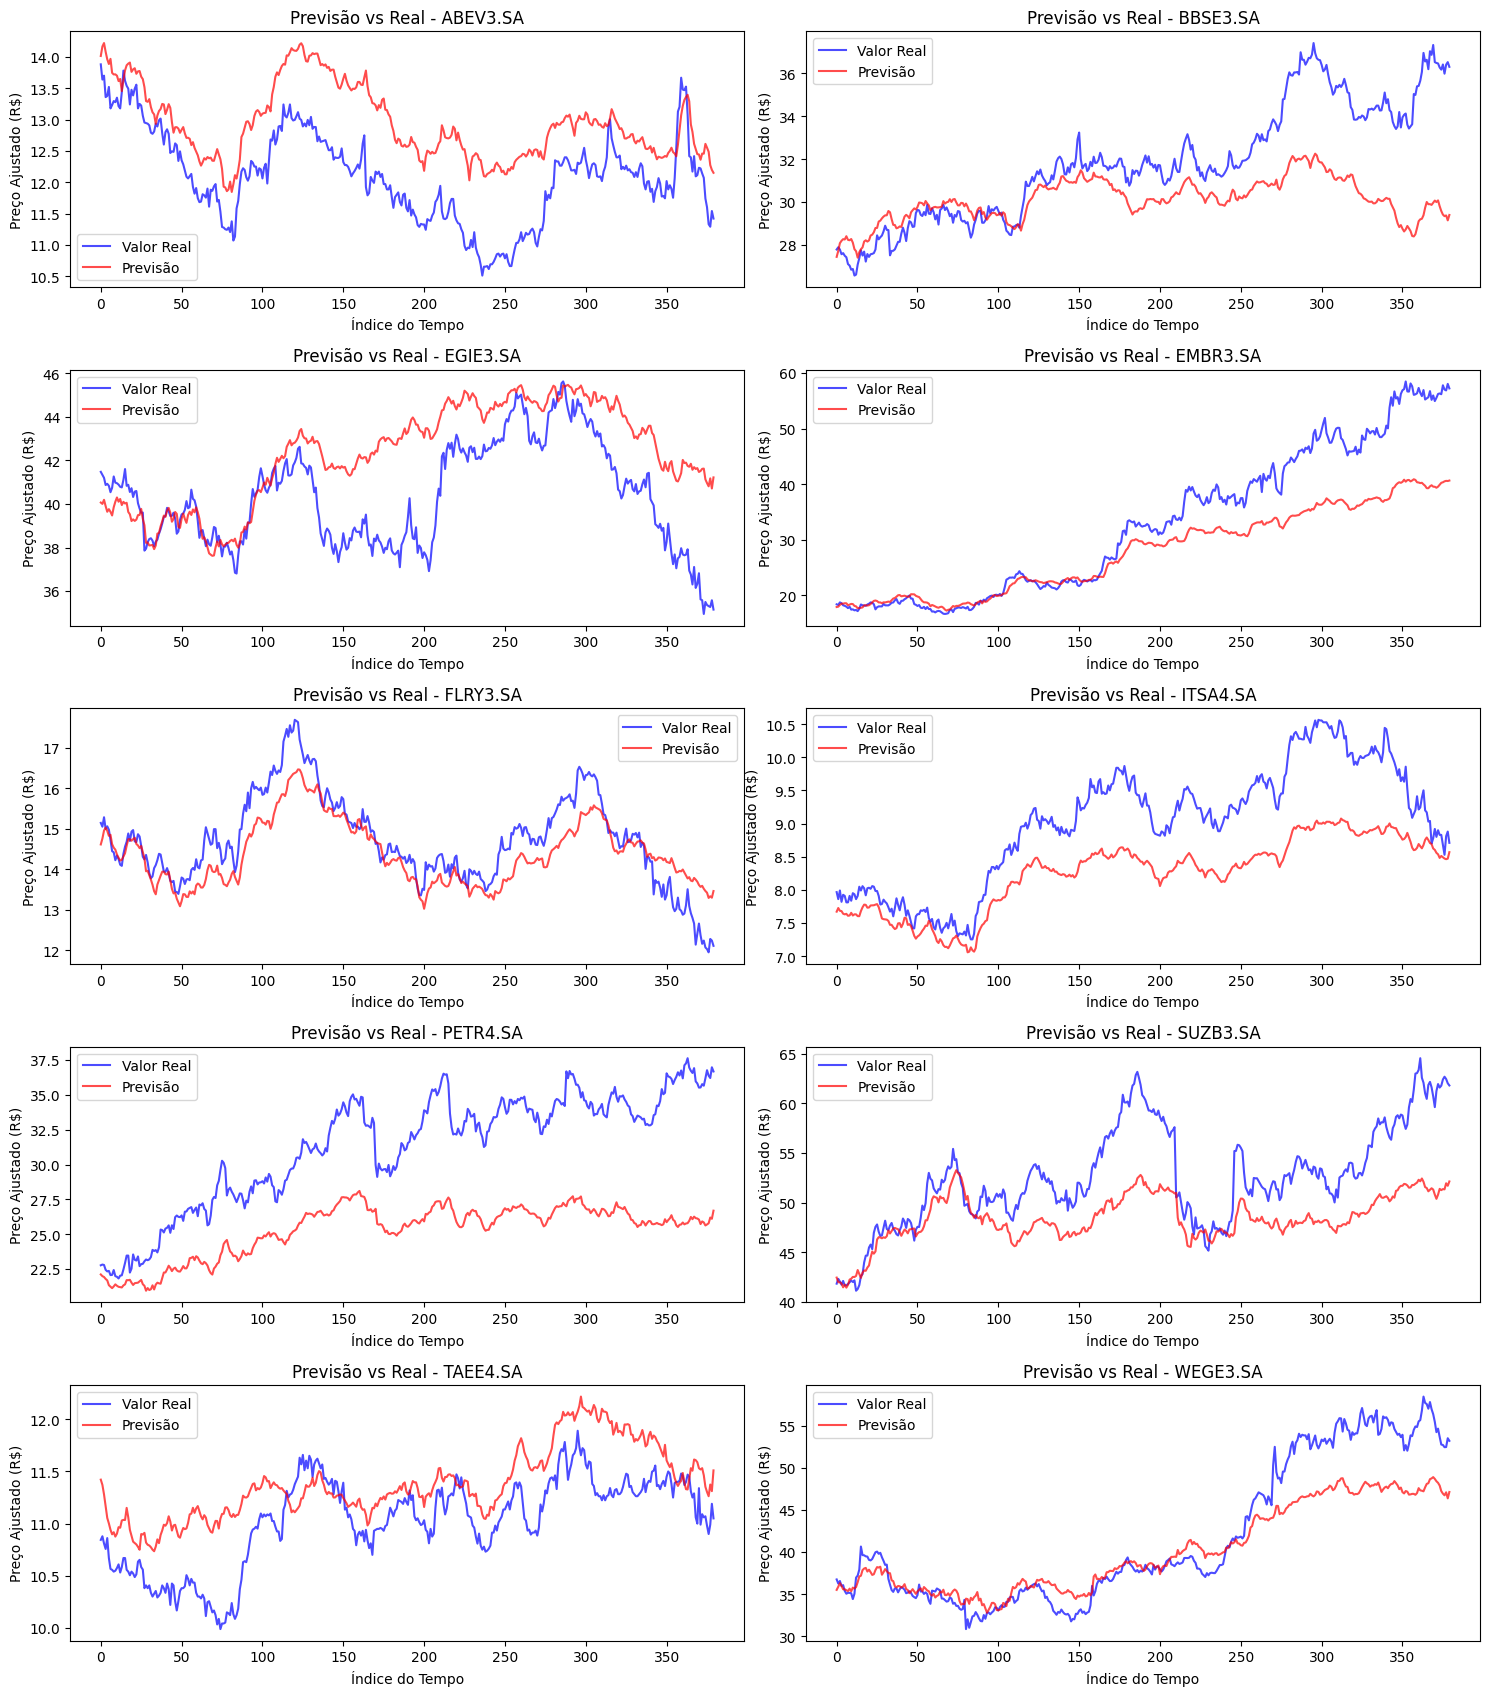

In [41]:
import matplotlib.pyplot as plt


# Lista de ações
acoes = ["ABEV3.SA", "BBSE3.SA", "EGIE3.SA", "EMBR3.SA", "FLRY3.SA", "ITSA4.SA", "PETR4.SA", "SUZB3.SA", "TAEE4.SA", "WEGE3.SA"]


# 1. Desnormalizar os dados (valores reais e previsões)
predicoes_desnormalizadas = scaler_y.inverse_transform(predicoes)
real_desnormalizados = scaler_y.inverse_transform(real)

# 2. Ajustando os dados para cada ação, considerando que temos 10 variáveis
predicoes_rescaled = predicoes_desnormalizadas.reshape(-1, 10) 
y_test_rescaled = real_desnormalizados.reshape(-1, 10)  

# 3. Criar o gráfico
plt.figure(figsize=(15, 20))

# Gerar os subgráficos para cada ação
for i in range(10):
    plt.subplot(6, 2, i+1)  

    
    plt.plot(y_test_rescaled[:, i], label='Valor Real', color='blue', alpha=0.7)
    plt.plot(predicoes_rescaled[:, i], label='Previsão', color='red', alpha=0.7)

    
    plt.title(f"Previsão vs Real - {acoes[i]}")
    plt.xlabel('Índice do Tempo')
    plt.ylabel('Preço Ajustado (R$)')
    plt.legend()


plt.tight_layout()
plt.show()


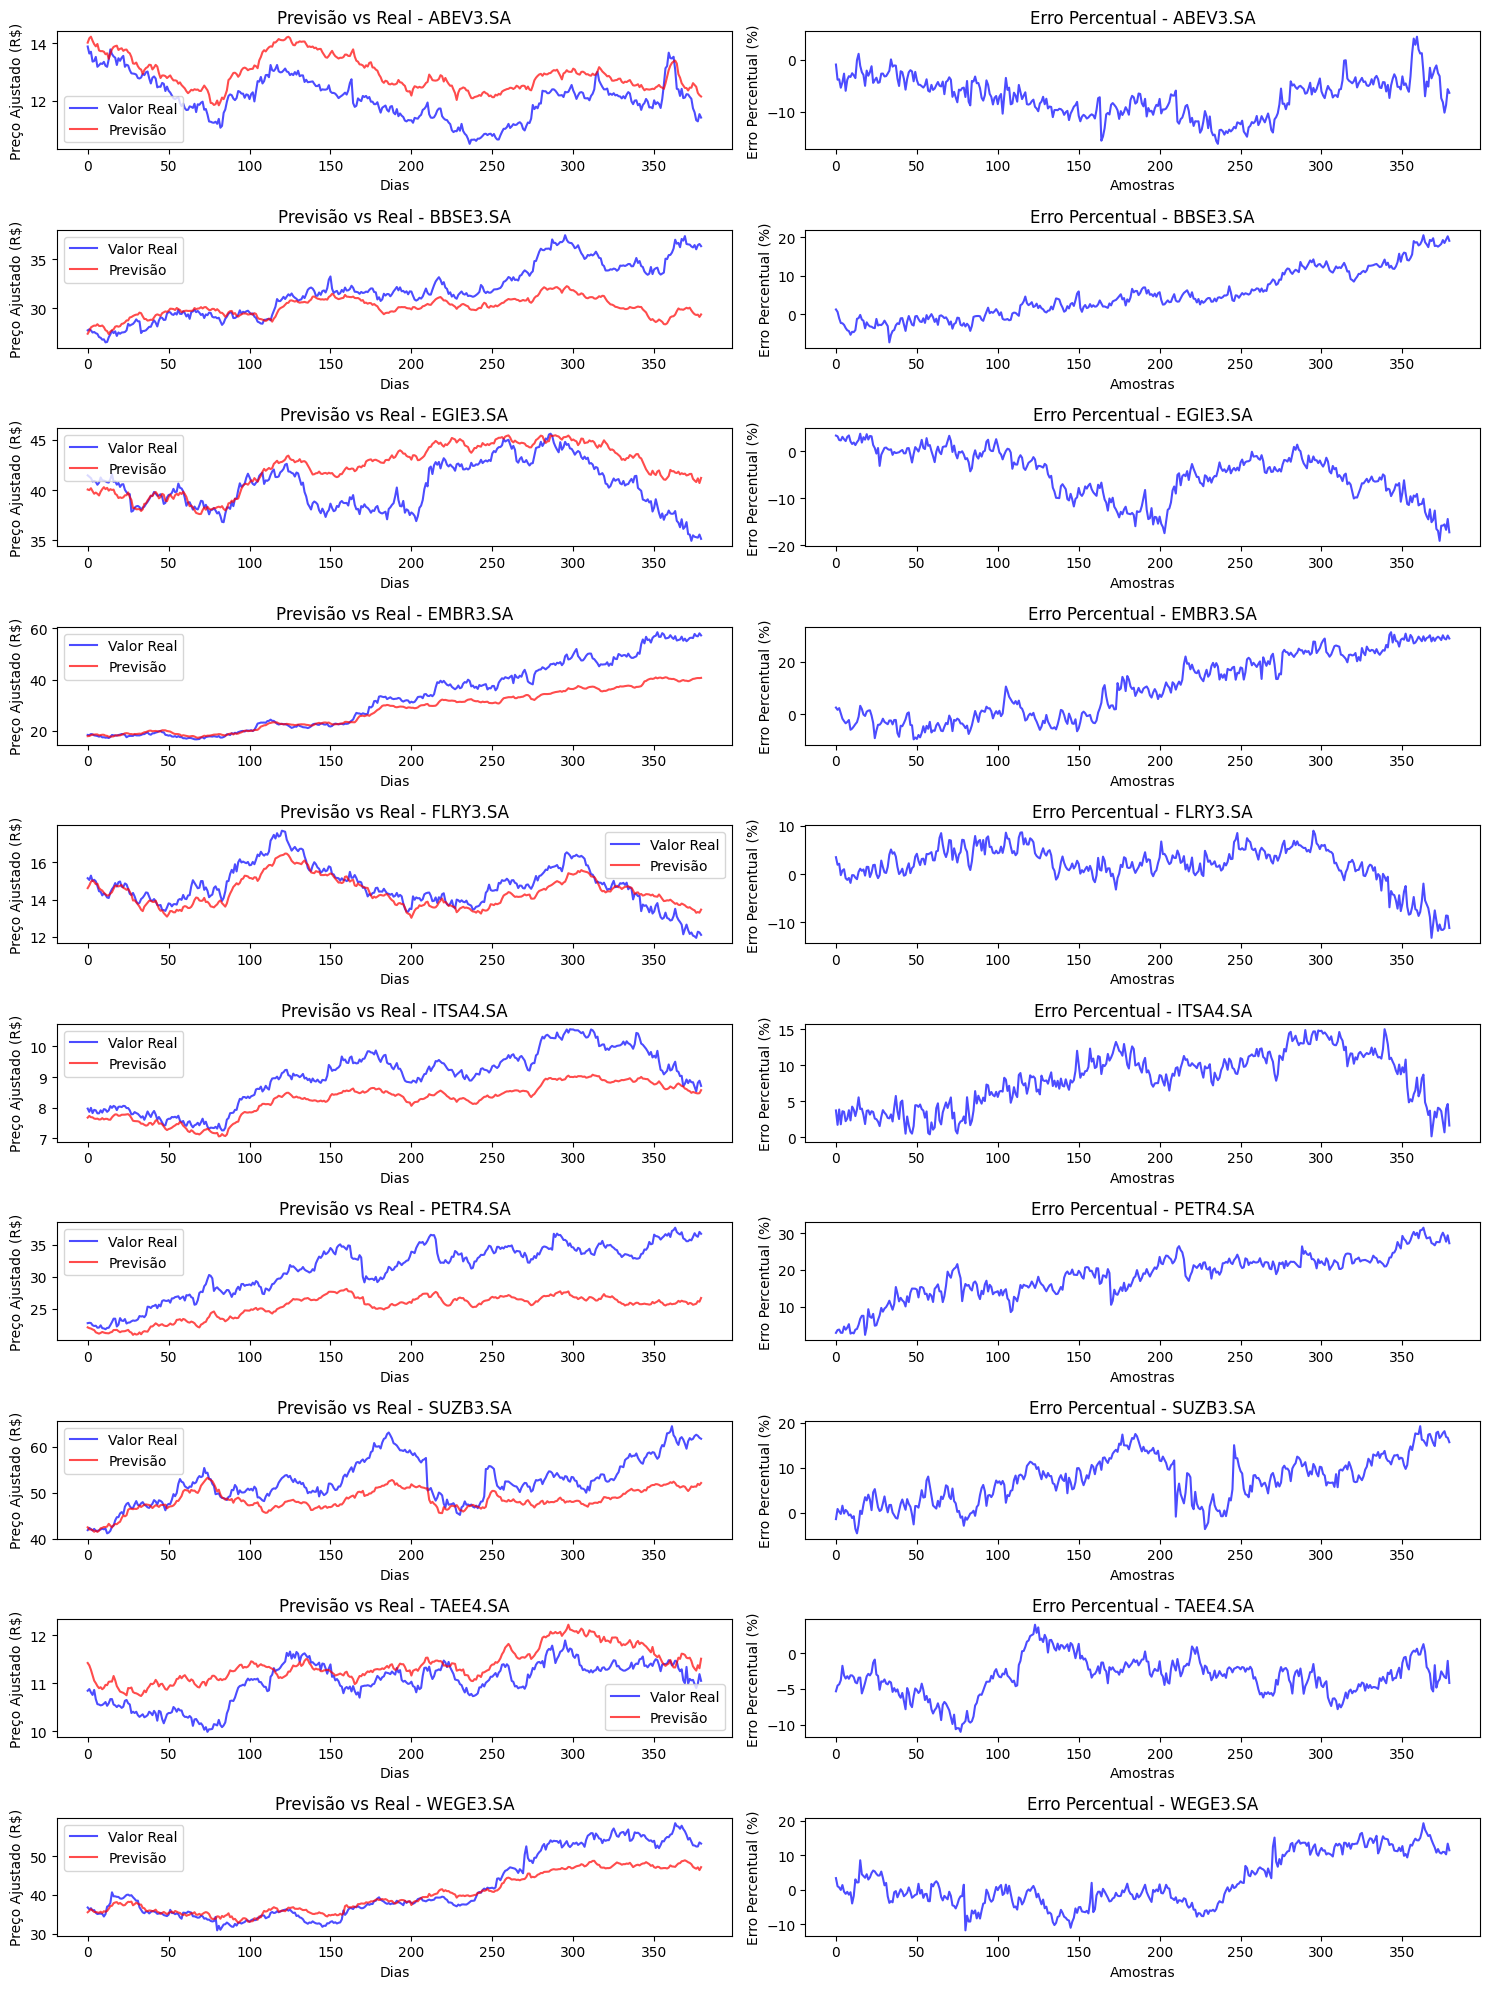

In [42]:

modelo.eval()  
predictions = []

with torch.no_grad():  
    for _, (data, _) in enumerate(test_dataloader):
        data = data.float().to(device)
        
        
        pred = modelo(data)
        
        
        predictions.append(pred.cpu().numpy())  # Converte as previsões para numpy e guarda


predictions = np.concatenate(predictions, axis=0)

# Desnormalizar os valores reais e previstos
real_desnormalizados = scaler_y.inverse_transform(y_test_scaled)  # Valores reais
predicoes_desnormalizadas = scaler_y.inverse_transform(predictions)  # Previsões


plt.figure(figsize=(15, 20))


for i in range(10):  
    
    plt.subplot(10, 2, 2*i+1)  # Posição ímpar (primeira coluna)
    plt.plot(real_desnormalizados[:, i], label='Valor Real', color='blue', alpha=0.7)
    plt.plot(predicoes_desnormalizadas[:, i], label='Previsão', color='red', alpha=0.7)
    plt.title(f"Previsão vs Real - {acoes[i]}")
    plt.xlabel('Dias')
    plt.ylabel('Preço Ajustado (R$)')
    plt.legend()

    # Cálculo do erro percentual
    erro_percentual = ((real_desnormalizados[:, i] - predicoes_desnormalizadas[:, i]) / real_desnormalizados[:, i]) * 100

    # Subgráfico para "Erro Percentual" (embaixo)
    plt.subplot(10, 2, 2*i+2)  # Posição par (segunda coluna)
    plt.plot(range(len(erro_percentual)), erro_percentual, color='blue', alpha=0.7)
    plt.title(f"Erro Percentual - {acoes[i]}")
    plt.xlabel('Amostras')
    plt.ylabel('Erro Percentual (%)')

# Ajuste o layout para não sobrepor os gráficos
plt.tight_layout()
plt.show()
